# Euclid VIS — MAP Fitting & Model/Residual Visualization

This notebook runs MAP (Maximum A Posteriori) fitting on Euclid VIS
multi-exposure data and visualizes the resulting model images and
normalized residuals for each exposure.

In [1]:
import warnings
warnings.filterwarnings("ignore", message=".*complex128.*", module="jax_galsim")

from pathlib import Path

import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt

from shine.config import InferenceConfig, MAPConfig
from shine.euclid.config import (
    EuclidDataConfig,
    EuclidInferenceConfig,
    SourceSelectionConfig,
)
from shine.euclid.data_loader import EuclidDataLoader
from shine.euclid.scene import MultiExposureScene, render_model_images
from shine.euclid.plots import plot_exposure_comparison
from shine.inference import Inference

%matplotlib inline

# --- Configuration ---
DATA_DIR = Path("../data/EUC_VIS_SWL")
MAX_SOURCES = 1000
MIN_SNR = 10.0
MAP_STEPS = 220
RNG_SEED = 42

## 1. Build Configuration

In [2]:
exposure_paths = sorted(
    str(p) for p in DATA_DIR.glob("EUC_VIS_SWL-DET-*_3-4-F.fits.gz")
)
bkg_paths = sorted(
    str(p) for p in DATA_DIR.glob("EUC_VIS_SWL-BKG-*_3-4-F.fits.gz")
)

config = EuclidInferenceConfig(
    data=EuclidDataConfig(
        exposure_paths=exposure_paths,
        psf_path=str(DATA_DIR / "PSF_3-4-F.fits.gz"),
        catalog_path=str(DATA_DIR / "catalogue_3-4-F.fits.gz"),
        background_paths=bkg_paths,
    ),
    sources=SourceSelectionConfig(max_sources=MAX_SOURCES, min_snr=MIN_SNR),
    inference=InferenceConfig(
        method="map",
        map_config=MAPConfig(enabled=True, num_steps=MAP_STEPS, learning_rate=0.002),
    ),
)

print(f"Exposures: {len(exposure_paths)}")
print(f"Background maps: {len(bkg_paths)}")
print(f"Max sources: {MAX_SOURCES}")
print(f"Min SNR: {MIN_SNR}")
print(f"MAP steps: {MAP_STEPS}")

Exposures: 3
Background maps: 3
Max sources: 1000
Min SNR: 10.0
MAP steps: 220


## 2. Load Data

In [3]:
loader = EuclidDataLoader(config)
data = loader.load()

print(f"Loaded {data.n_sources} sources across {data.n_exposures} exposures")
print(f"Image shape: ({data.image_ny}, {data.image_nx})")
print(f"Number of sources: {len(data.catalog_flux_adu)}")
print(f"Catalog flux range: [{data.catalog_flux_adu.min():.1f}, {data.catalog_flux_adu.max():.1f}] ADU")
print(f"Catalog HLR range: [{data.catalog_hlr_arcsec.min():.3f}, {data.catalog_hlr_arcsec.max():.3f}] arcsec")

Loaded 523 sources across 3 exposures
Image shape: (2066, 2048)
Number of sources: 523
Catalog flux range: [541.0, 1941681.9] ADU
Catalog HLR range: [0.124, 3.719] arcsec


## 3. Build Model & Run MAP Inference

In [4]:
scene = MultiExposureScene(config, data)
model = scene.build_model()

# Catalog-based initial parameters: safe values where JAX-GalSim rendering
# is always well-behaved (zero ellipticity/shear, catalog flux/hlr).
init_params = {
    "g1": jnp.float32(0.0),
    "g2": jnp.float32(0.0),
    "flux": jnp.asarray(data.catalog_flux_adu),
    "hlr": jnp.asarray(data.catalog_hlr_arcsec),
    "e1": jnp.zeros(data.n_sources),
    "e2": jnp.zeros(data.n_sources),
    "dx": jnp.zeros(data.n_sources),
    "dy": jnp.zeros(data.n_sources),
}

engine = Inference(model, config.inference)
rng = jax.random.PRNGKey(RNG_SEED)

print("Running MAP inference...")
idata = engine.run(rng, observed_data=data.images, init_params=init_params)
print("Done.")

Running MAP inference...


100%|██████████| 220/220 [01:53<00:00,  1.93it/s, init loss: 64640652.0000, avg. loss [210-220]: 58695696.0000]


Done.


## 4. Extract MAP Parameters

In [9]:
posterior = idata.posterior

# Extract point estimates (chain=0, draw=0 for MAP)
map_params = {}
for name in ["g1", "g2", "flux", "hlr", "e1", "e2", "dx", "dy"]:
    vals = posterior[name].values
    # Squeeze out chain and draw dimensions
    map_params[name] = np.squeeze(vals)

print(f"MAP g1 = {float(map_params['g1']):.6f}")
print(f"MAP g2 = {float(map_params['g2']):.6f}")
# print(f"MAP flux = {map_params['flux']}")
# print(f"MAP hlr  = {map_params['hlr']}")
# print(f"MAP e1   = {map_params['e1']}")
# print(f"MAP e2   = {map_params['e2']}")
# print(f"MAP dx   = {map_params['dx']}")
# print(f"MAP dy   = {map_params['dy']}")

MAP g1 = -0.094575
MAP g2 = -0.029657


## 5. Render Model Images

In [6]:
model_images = render_model_images(
    map_params,
    data,
    pixel_scale=config.data.pixel_scale,
    stamp_sizes=config.galaxy_stamp_sizes,
)

print(f"Model images shape: {model_images.shape}")
print(f"Expected shape: ({data.n_exposures}, {data.image_ny}, {data.image_nx})")

Model images shape: (3, 2066, 2048)
Expected shape: (3, 2066, 2048)


## 6. Plot Observed vs Model vs Residual

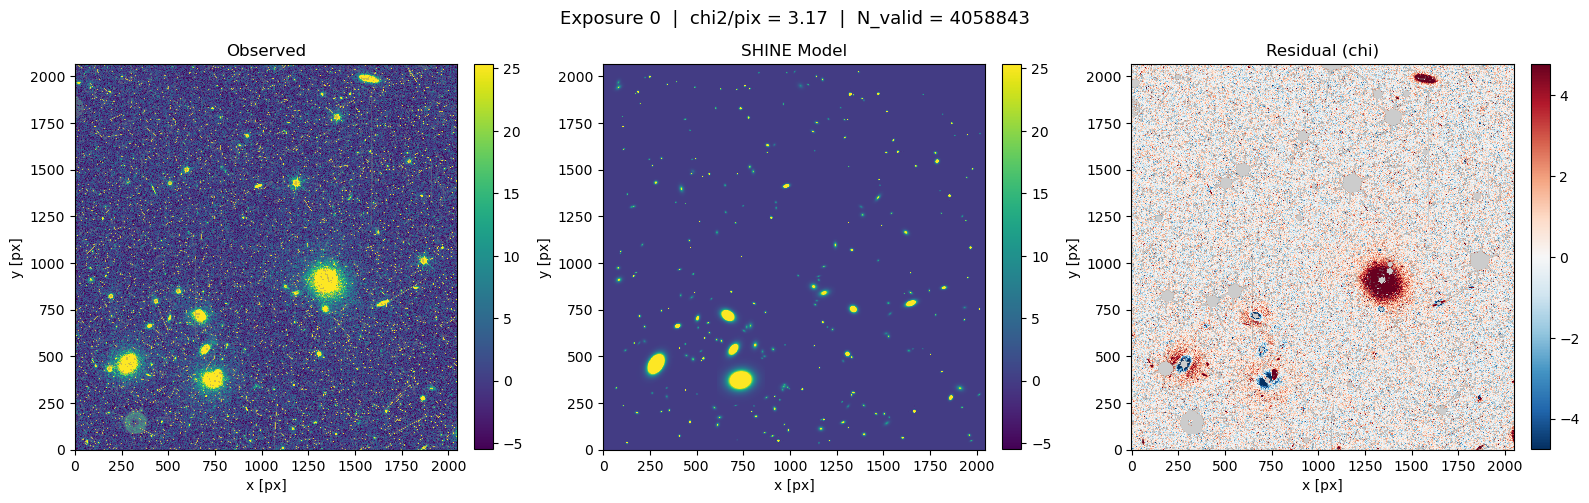

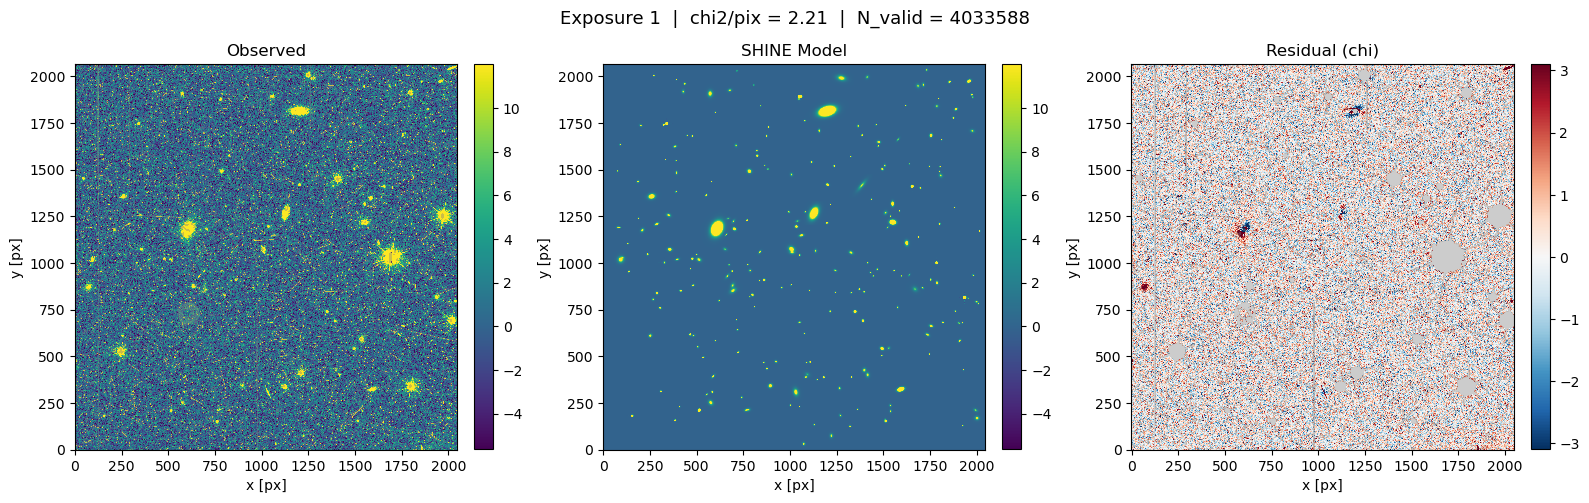

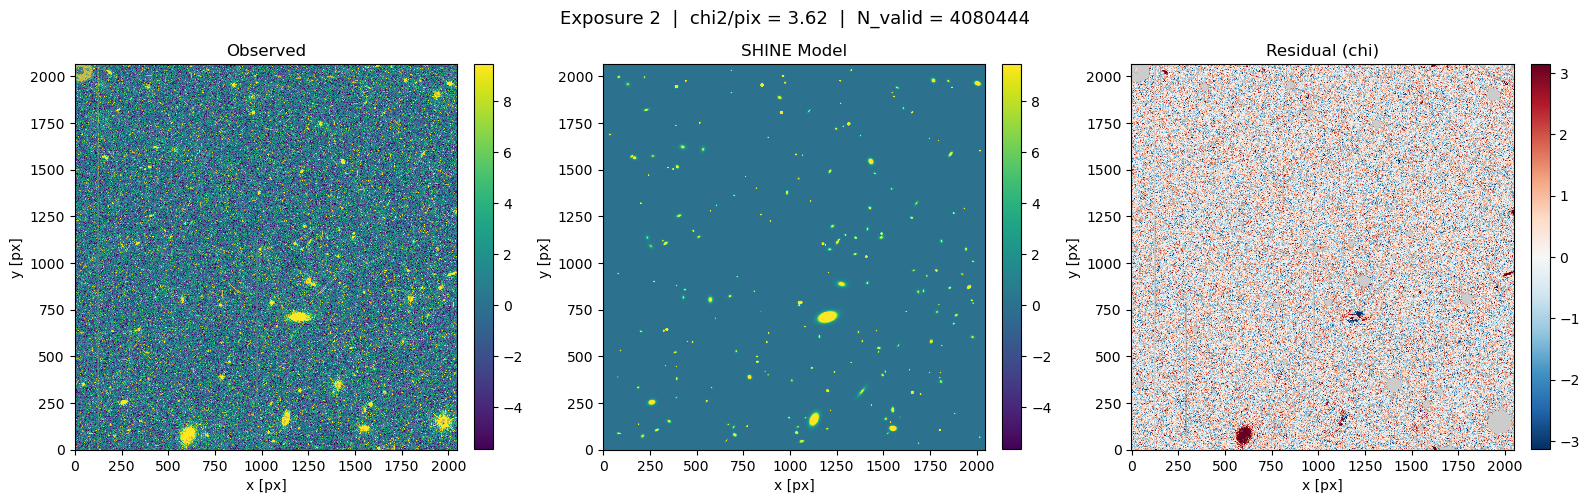

In [7]:
# Build a broader residual mask that also excludes bright-star halos
# and ghost-affected pixels from the VIS flag map.
# Bit 5 = GHOST, bit 18 = STARSIGNAL, bit 19 = SATURATEDSTAR
RESIDUAL_EXCLUDE_BITS = 0x1 | (1 << 5) | (1 << 18) | (1 << 19)

for j in range(data.n_exposures):
    residual_mask = (data.flag_maps[j] & RESIDUAL_EXCLUDE_BITS) == 0

    fig = plot_exposure_comparison(
        observed=data.images[j],
        model=model_images[j],
        noise_sigma=data.noise_sigma[j],
        mask=data.masks[j],
        exposure_idx=j,
        residual_mask=residual_mask,
    )
    plt.show()

## 7. Source Map & Exposure Arrangement

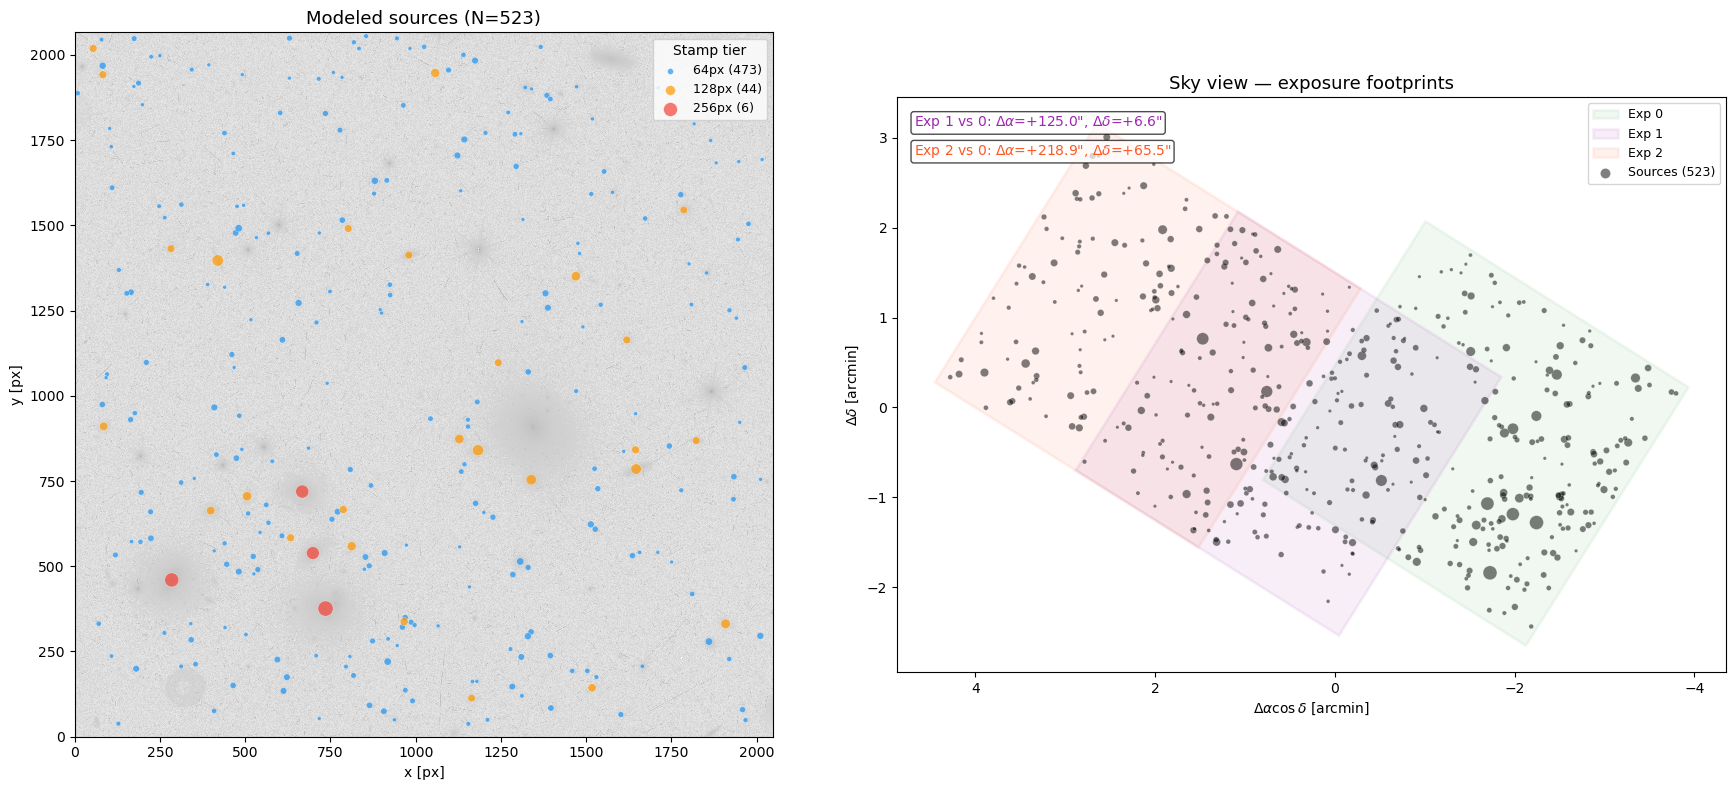


Visibility summary:
  Exp 0:  264 / 523 sources visible
  Exp 1:  243 / 523 sources visible
  Exp 2:  205 / 523 sources visible
  All 3 exposures: 0 sources

Field center: RA=267.94119°, Dec=65.61393°


In [8]:
from matplotlib.patches import Rectangle, Polygon

pos0 = np.asarray(data.pixel_positions[:, 0, :])  # reference: exposure 0
tiers = np.asarray(data.source_stamp_tier)
hlr = np.asarray(data.catalog_hlr_arcsec)
vis = np.asarray(data.source_visible)
stamp_sizes = config.galaxy_stamp_sizes

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

# --- Left: Source map colored by stamp tier ---
ax1.imshow(
    np.arcsinh(np.asarray(data.images[0])),
    origin="lower", cmap="gray_r", alpha=0.3, interpolation="nearest",
)

tier_colors = ["#2196F3", "#FF9800", "#F44336"]
for t, ss in enumerate(stamp_sizes):
    m = tiers == t
    if m.sum() == 0:
        continue
    ax1.scatter(
        pos0[m, 0], pos0[m, 1],
        s=np.clip(hlr[m] * 40, 8, 120),
        c=tier_colors[t], alpha=0.7,
        edgecolors="white", linewidths=0.3,
        label=f"{ss}px ({m.sum()})",
    )

ax1.set_xlim(0, data.image_nx)
ax1.set_ylim(0, data.image_ny)
ax1.set_aspect("equal")
ax1.legend(title="Stamp tier", loc="upper right", fontsize=9)
ax1.set_title(f"Modeled sources (N={data.n_sources})", fontsize=13)
ax1.set_xlabel("x [px]")
ax1.set_ylabel("y [px]")

# --- Right: Sky view — exposure footprints & source positions ---
ra = data.catalog_ra
dec = data.catalog_dec
corners = data.exposure_corners_sky  # (n_exp, 4, 2) = (RA, Dec)

# Reference RA for relative coordinates (arcmin offset)
ra_ref = ra.mean()
dec_ref = dec.mean()
cos_dec = np.cos(np.radians(dec_ref))

# Source positions in arcmin offset from field center
src_dra = (ra - ra_ref) * cos_dec * 60.0   # arcmin
src_ddec = (dec - dec_ref) * 60.0

exp_colors = ["#4CAF50", "#9C27B0", "#FF5722"]

# Plot exposure footprints as polygons
for j in range(data.n_exposures):
    c_ra = corners[j, :, 0]
    c_dec = corners[j, :, 1]
    c_dra = (c_ra - ra_ref) * cos_dec * 60.0
    c_ddec = (c_dec - dec_ref) * 60.0
    poly = Polygon(
        np.column_stack([c_dra, c_ddec]),
        closed=True, fill=True,
        facecolor=exp_colors[j], alpha=0.08,
        edgecolor=exp_colors[j], linewidth=2.0,
        label=f"Exp {j}",
    )
    ax2.add_patch(poly)

# Plot source positions (all sources, single color)
ax2.scatter(
    src_dra, src_ddec,
    s=np.clip(hlr * 40, 6, 100), c="k", alpha=0.5,
    edgecolors="white", linewidths=0.3,
    label=f"Sources ({data.n_sources})", zorder=3,
)

# Annotate dither offsets in arcsec
for j in range(1, data.n_exposures):
    # Offset between exposure centers
    cen_ra_0 = corners[0, :, 0].mean()
    cen_dec_0 = corners[0, :, 1].mean()
    cen_ra_j = corners[j, :, 0].mean()
    cen_dec_j = corners[j, :, 1].mean()
    dra_asec = (cen_ra_j - cen_ra_0) * cos_dec * 3600.0
    ddec_asec = (cen_dec_j - cen_dec_0) * 3600.0
    ax2.annotate(
        f"Exp {j} vs 0: $\\Delta\\alpha$={dra_asec:+.1f}\", $\\Delta\\delta$={ddec_asec:+.1f}\"",
        xy=(0.02, 0.97 - (j - 1) * 0.05), xycoords="axes fraction",
        fontsize=10, color=exp_colors[j], va="top",
        bbox=dict(boxstyle="round,pad=0.2", fc="white", alpha=0.7),
    )

ax2.set_aspect("equal")
ax2.invert_xaxis()  # RA increases to the left
ax2.legend(loc="upper right", fontsize=9)
ax2.set_title("Sky view — exposure footprints", fontsize=13)
ax2.set_xlabel("$\\Delta\\alpha\\cos\\delta$ [arcmin]")
ax2.set_ylabel("$\\Delta\\delta$ [arcmin]")
ax2.autoscale_view()

fig.tight_layout()
plt.show()

# Visibility summary
print(f"\nVisibility summary:")
for j in range(data.n_exposures):
    print(f"  Exp {j}: {int(vis[:, j].sum()):>4d} / {data.n_sources} sources visible")
all_vis = vis.all(axis=1)
n_all = int(all_vis.sum())
print(f"  All {data.n_exposures} exposures: {n_all} sources")
print(f"\nField center: RA={ra_ref:.5f}°, Dec={dec_ref:.5f}°")